In [13]:
import pandas as pd

## Show all review CSV files

In [14]:
google_df = pd.read_csv("csv_files/google.csv", encoding='latin-1') #need latin-1 encoding for the google reviews found through trial & error

In [15]:
google_df.head()

,date,rating,review_text
0,3/9/2024 3:38,5,NaN
1,3/8/2024 10:42,5,Great selection of beer! We loved the atmosphere.
2,3/8/2024 9:55,5,Women's International Day at MadTree Brewery. ...
3,3/8/2024 2:07,5,Authentic place. Great vibe
4,3/7/2024 14:36,5,NaN


In [16]:
yelp_df = pd.read_csv("csv_files/yelp.csv")

In [17]:
yelp_df.head()

,date,rating,review_text
0,14-Mar-24,2,What has happened to Madtree? It was the best ...
1,15-Feb-24,5,Great spot to hang out with a variety of optio...
2,25-Jan-24,5,MadTree Brewing is an absolute gem with an inc...
3,25-Jan-24,5,MadTree has long been our cherished gathering ...
4,18-Jan-24,5,I love coming here whether it's after work or ...


In [18]:
trip_df = pd.read_csv("csv_files/trip.csv")

In [19]:
trip_df

,date,rating,review_text
0,11/15/2023,5,Great environment and beers! Love the indoor/o...
1,10/30/2023,5,My husband and I went to Madtree this weekend ...
2,10/16/2023,3,Experiences here are pretty much hit or miss. ...
3,8/19/2023,5,"Brews were great, and the flight was a good de..."
4,11/30/2022,3,"Pros: cool venue, quality pizza and drinks\nCo..."
5,5/12/2022,5,"I love MadTree. I love their beer, I love thei..."
6,8/31/2021,5,One of the best beer gardens I have been to in...


### We want to consolidate all of the reviews into one big CSV file

In [20]:
len(google_df), len(yelp_df), len(trip_df)

(500, 135, 7)

Convert 'date' column to standard format

In [21]:
google_df['date'] = pd.to_datetime(google_df['date'])

In [22]:
google_df.head()

,date,rating,review_text
0,2024-03-09 03:38:00,5,NaN
1,2024-03-08 10:42:00,5,Great selection of beer! We loved the atmosphere.
2,2024-03-08 09:55:00,5,Women's International Day at MadTree Brewery. ...
3,2024-03-08 02:07:00,5,Authentic place. Great vibe
4,2024-03-07 14:36:00,5,NaN


In [23]:
yelp_df['date'] = pd.to_datetime(yelp_df['date'])

In [24]:
yelp_df.head()

,date,rating,review_text
0,2024-03-14,2,What has happened to Madtree? It was the best ...
1,2024-02-15,5,Great spot to hang out with a variety of optio...
2,2024-01-25,5,MadTree Brewing is an absolute gem with an inc...
3,2024-01-25,5,MadTree has long been our cherished gathering ...
4,2024-01-18,5,I love coming here whether it's after work or ...


In [25]:
trip_df['date'] = pd.to_datetime(trip_df['date'])

In [26]:
trip_df.head()

,date,rating,review_text
0,2023-11-15,5,Great environment and beers! Love the indoor/o...
1,2023-10-30,5,My husband and I went to Madtree this weekend ...
2,2023-10-16,3,Experiences here are pretty much hit or miss. ...
3,2023-08-19,5,"Brews were great, and the flight was a good de..."
4,2022-11-30,3,"Pros: cool venue, quality pizza and drinks\nCo..."


In [27]:
consolidated_df = pd.concat([google_df, yelp_df, trip_df], ignore_index=True)

In [28]:
consolidated_df

,date,rating,review_text
0,2024-03-09 03:38:00,5,NaN
1,2024-03-08 10:42:00,5,Great selection of beer! We loved the atmosphere.
2,2024-03-08 09:55:00,5,Women's International Day at MadTree Brewery. ...
3,2024-03-08 02:07:00,5,Authentic place. Great vibe
4,2024-03-07 14:36:00,5,NaN
...,...,...,...
637,2023-10-16 00:00:00,3,Experiences here are pretty much hit or miss. ...
638,2023-08-19 00:00:00,5,"Brews were great, and the flight was a good de..."
639,2022-11-30 00:00:00,3,"Pros: cool venue, quality pizza and drinks\nCo..."
640,2022-05-12 00:00:00,5,"I love MadTree. I love their beer, I love thei..."


642 rows matches the summed lengths of each individual dataframe.

In [29]:
consolidated_df[490: 510] # Where google reviews meet yelp reviews in the new consolidated df

,date,rating,review_text
490,2021-08-04 19:11:00,5,"Great airy space indoors, and lovely large pat..."
491,2021-08-04 02:40:00,5,I went to the Yottaquest event that they were ...
492,2021-08-04 02:07:00,5,"Great beer, metric tons of seating."
493,2021-08-03 17:52:00,5,Very cool brewery with a relaxed vibe and exce...
494,2021-08-01 01:18:00,5,NaN
495,2021-07-31 20:29:00,5,NaN
496,2021-07-31 11:54:00,5,Spacious and open. Great beer selection and ou...
497,2021-07-30 15:55:00,5,The only issues with this place are that the p...
498,2021-07-28 13:56:00,5,Great outdoor space for dogs! And the beer nev...
499,2021-07-27 03:09:00,5,NaN


In [30]:
consolidated_df['review_text'].isna()

0       True
1      False
2      False
3      False
4       True
       ...  
637    False
638    False
639    False
640    False
641    False
Name: review_text, Length: 642, dtype: bool

In [31]:
consolidated_df.isna().sum()

date             0
rating           0
review_text    217
dtype: int64

Let's get rid of the rows with NaN values.

In [32]:
cleaned_df = consolidated_df.dropna()

In [33]:
len(cleaned_df) # Should be 642 - 217 = 425

425

Now our data is all consolidated and the rows with missing review text have been removed. All that's left is to sort it by date.

In [34]:
sorted_df = cleaned_df.sort_values(by='date')

In [35]:
sorted_df

,date,rating,review_text
634,2021-07-03 00:00:00,4,I loved the food here so much. But I have to s...
633,2021-07-04 00:00:00,5,"Awesome!! Love the space, large indoor space, ..."
632,2021-07-08 00:00:00,4,Busy summer evening at happy hour so tables we...
631,2021-07-09 00:00:00,4,Been here a few times and the atmosphere is de...
630,2021-07-11 00:00:00,5,Just a fun place. Even though we are vaccinate...
...,...,...,...
5,2024-03-02 22:16:00,4,"Super fun and active, great beer."
3,2024-03-08 02:07:00,5,Authentic place. Great vibe
2,2024-03-08 09:55:00,5,Women's International Day at MadTree Brewery. ...
1,2024-03-08 10:42:00,5,Great selection of beer! We loved the atmosphere.


In [36]:
# # Save sorted df to csv
# sorted_df.to_csv("sorted.csv", index=False)

In [37]:
# Add sentiment scores based on 'rating' column
df = pd.read_csv("sorted.csv")
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

In [38]:
df

,date,rating,review_text,sentiment
0,2021-07-03 00:00:00,4,I loved the food here so much. But I have to s...,positive
1,2021-07-04 00:00:00,5,"Awesome!! Love the space, large indoor space, ...",positive
2,2021-07-08 00:00:00,4,Busy summer evening at happy hour so tables we...,positive
3,2021-07-09 00:00:00,4,Been here a few times and the atmosphere is de...,positive
4,2021-07-11 00:00:00,5,Just a fun place. Even though we are vaccinate...,positive
...,...,...,...,...
420,2024-03-02 22:16:00,4,"Super fun and active, great beer.",positive
421,2024-03-08 02:07:00,5,Authentic place. Great vibe,positive
422,2024-03-08 09:55:00,5,Women's International Day at MadTree Brewery. ...,positive
423,2024-03-08 10:42:00,5,Great selection of beer! We loved the atmosphere.,positive


In [39]:
# Let's make a copy of the dataframe in case we need to revert back
df_copy = df

### Text Cleaning
Let's clean the text to prepare it for analysis

In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rwynn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rwynn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rwynn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [41]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [42]:
df['cleaned_review_text'] = df['review_text'].apply(clean_text)
df.head()

,date,rating,review_text,sentiment,cleaned_review_text
0,2021-07-03 00:00:00,4,I loved the food here so much. But I have to s...,positive,loved food much say service lacking food order...
1,2021-07-04 00:00:00,5,"Awesome!! Love the space, large indoor space, ...",positive,awesome love space large indoor space even lar...
2,2021-07-08 00:00:00,4,Busy summer evening at happy hour so tables we...,positive,busy summer evening happy hour table little ha...
3,2021-07-09 00:00:00,4,Been here a few times and the atmosphere is de...,positive,time atmosphere decent beer well nothing reall...
4,2021-07-11 00:00:00,5,Just a fun place. Even though we are vaccinate...,positive,fun place even though vaccinated sat outside f...


### Exploratory Data Analysis (EDA)
Let's explore the data a bit.

In [43]:
import matplotlib.pyplot as plt

In [44]:
sentiment_distribution = df['sentiment'].value_counts(normalize=True) # `normalize=True` returns percentages, `False` returns raw counts
sentiment_distribution

positive    0.868235
negative    0.131765
Name: sentiment, dtype: float64

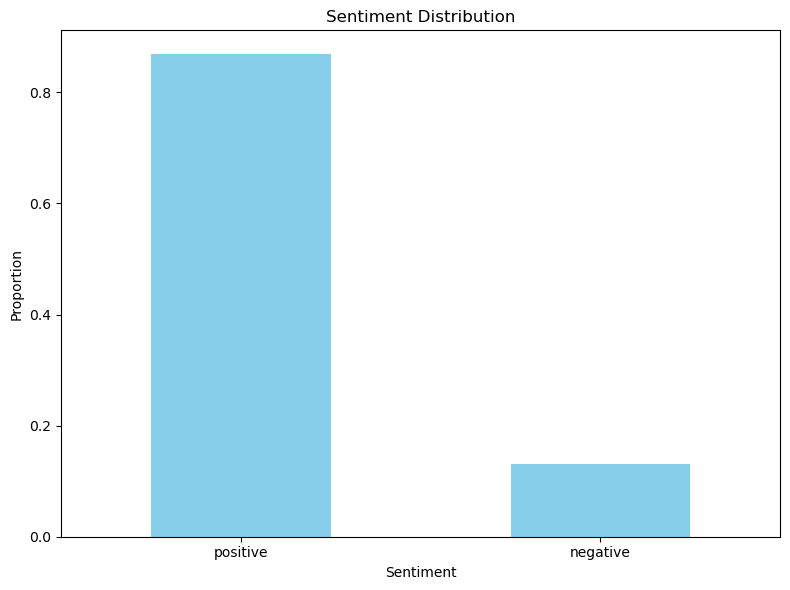

In [45]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

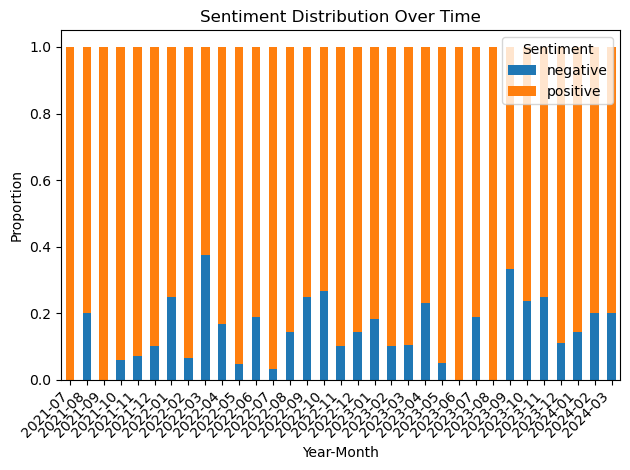

In [46]:
# Convert 'date' column to 'datetime' dtype if needed
df['date'] = pd.to_datetime(df['date'])

# Compare sentiment distribution across different time periods (e.g., months or years)
df['year_month'] = df['date'].dt.to_period('M')
sentiment_by_month = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_month_percentage = sentiment_by_month.div(sentiment_by_month.sum(axis=1), axis=0)

# Plot sentiment distribution over time
plt.figure(figsize=(10, 6))
sentiment_by_month_percentage.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
df.head()

,date,rating,review_text,sentiment,cleaned_review_text,year_month
0,2021-07-03,4,I loved the food here so much. But I have to s...,positive,loved food much say service lacking food order...,2021-07
1,2021-07-04,5,"Awesome!! Love the space, large indoor space, ...",positive,awesome love space large indoor space even lar...,2021-07
2,2021-07-08,4,Busy summer evening at happy hour so tables we...,positive,busy summer evening happy hour table little ha...,2021-07
3,2021-07-09,4,Been here a few times and the atmosphere is de...,positive,time atmosphere decent beer well nothing reall...,2021-07
4,2021-07-11,5,Just a fun place. Even though we are vaccinate...,positive,fun place even though vaccinated sat outside f...,2021-07


In [48]:
from sklearn.feature_extraction.text import CountVectorizer

def extract_ngrams(text, sentiment, pos_or_neg, ngram_range=(1, 2)):
    # Filter reviews by sentiment
    text_filtered = text[sentiment == pos_or_neg]
    # Initialize CountVectorizer to generate n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    # Fit and transform text data to extract n-grams
    X = vectorizer.fit_transform(text_filtered)
    # Get the feature names
    ngrams = vectorizer.get_feature_names_out()    
    # Get the count of each n-gram
    ngram_counts = X.sum(axis=0).A1
    # Create a dict mapping ngram to its count
    ngram_freq = dict(zip(ngrams, ngram_counts))
    # Sort the dict by frequency in descending order
    sorted_ngram_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_ngram_freq

great beer: 40
great place: 38
dog friendly: 25
great atmosphere: 22
beer selection: 21
beer great: 20
fire pizza: 19
good beer: 19
catch fire: 18
beer good: 17


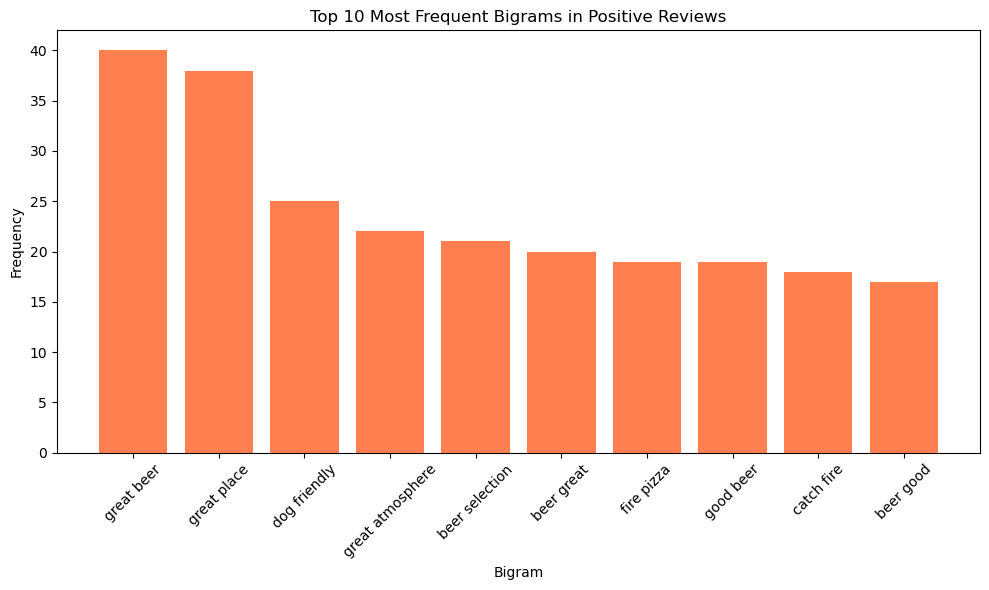

In [49]:
# Extract bigrams from cleaned review text
ngrams = extract_ngrams(df['cleaned_review_text'], df['sentiment'], 'positive', ngram_range=(2, 2))

# Display top 10 most frequent bigrams
top_ngrams = ngrams[:10]
for ngram, freq in top_ngrams:
    print(f'{ngram}: {freq}')

# Plot the most frequent bigrams
plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_ngrams), color="coral")
plt.title('Top 10 Most Frequent Bigrams in Positive Reviews')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

food ready: 6
parking lot: 5
beer good: 4
fire pizza: 4
food drink: 3
friday night: 3
good beer: 3
love beer: 3
beer okay: 2
beer pizza: 2


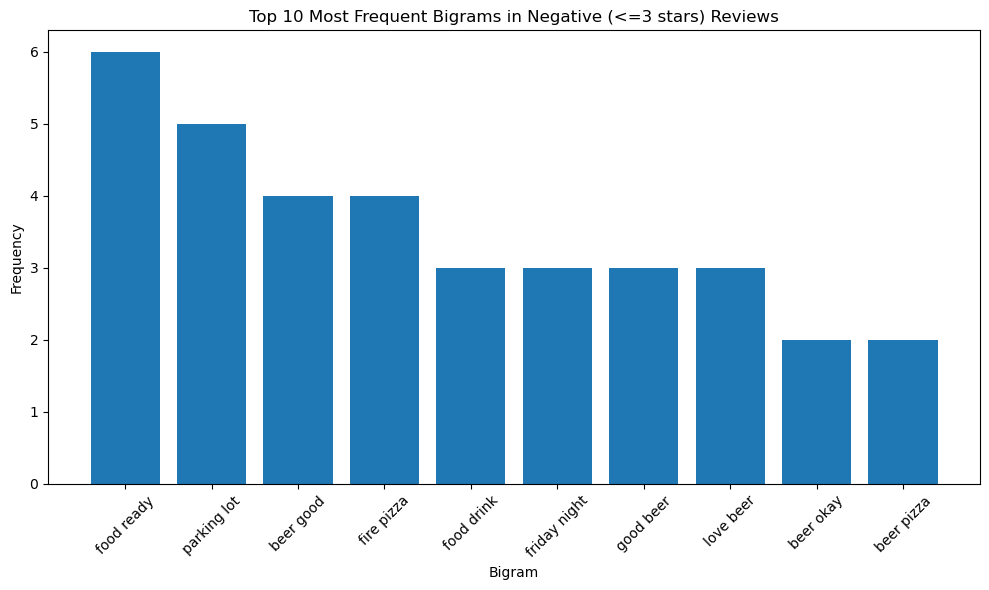

In [50]:
# Extract bigrams from cleaned review text
ngrams = extract_ngrams(df['cleaned_review_text'], df['sentiment'], 'negative', ngram_range=(2, 2))

# Display top 10 most frequent bigrams
top_ngrams = ngrams[:10]
for ngram, freq in top_ngrams:
    print(f'{ngram}: {freq}')

# Plot the most frequent bigrams
plt.figure(figsize=(10, 6))
plt.bar(*zip(*top_ngrams))
plt.title('Top 10 Most Frequent Bigrams in Negative (<=3 stars) Reviews')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Let's try out some Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF) to see if we can find any latent topics

In [51]:
# LDA

from gensim import corpora, models
# Filter for negative reviews
negative_reviews = df[df['sentiment'] == 'negative']

# Tokenize the cleaned review text
tokenized_reviews = negative_reviews['cleaned_review_text'].apply(lambda x: x.split())

# Create a dictionary mapping words to unique ids
dictionary = corpora.Dictionary(tokenized_reviews)

# Create a bag-of-words representation of the corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Train the LDA model
num_topics = 5 # Specify the number of topics
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics
for topic in lda_model.print_topics():
    print(topic)

(0, '0.013*"place" + 0.012*"kid" + 0.012*"table" + 0.011*"madtree" + 0.011*"parking" + 0.010*"dog" + 0.010*"time" + 0.010*"brewery" + 0.010*"lot" + 0.008*"pizza"')
(1, '0.021*"food" + 0.012*"place" + 0.011*"beer" + 0.010*"madtree" + 0.010*"drink" + 0.009*"staff" + 0.008*"like" + 0.008*"pizza" + 0.008*"people" + 0.008*"even"')
(2, '0.022*"beer" + 0.018*"good" + 0.013*"food" + 0.010*"pizza" + 0.010*"dog" + 0.009*"outside" + 0.009*"love" + 0.009*"coffee" + 0.009*"wing" + 0.007*"get"')
(3, '0.013*"music" + 0.008*"could" + 0.008*"bartender" + 0.008*"time" + 0.008*"really" + 0.008*"prefer" + 0.008*"great" + 0.007*"beer" + 0.006*"experience" + 0.006*"bad"')
(4, '0.013*"pizza" + 0.011*"beer" + 0.011*"time" + 0.011*"rude" + 0.011*"atmosphere" + 0.008*"drink" + 0.008*"bar" + 0.008*"enjoyed" + 0.008*"didnt" + 0.008*"family"')


Now let's try to visualize.

In [52]:
# Install wordcloud
import sys
print(sys.executable)

C:\Users\rwynn\anaconda3\python.exe


In [53]:
!C:\Users\rwynn\anaconda3\python.exe -m pip install wordcloud


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\rwynn\anaconda3\python.exe -m pip install --upgrade pip


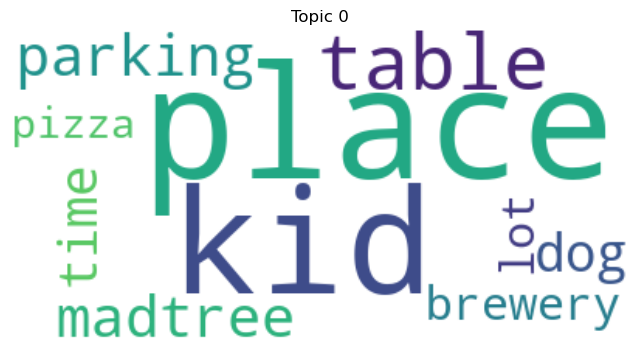

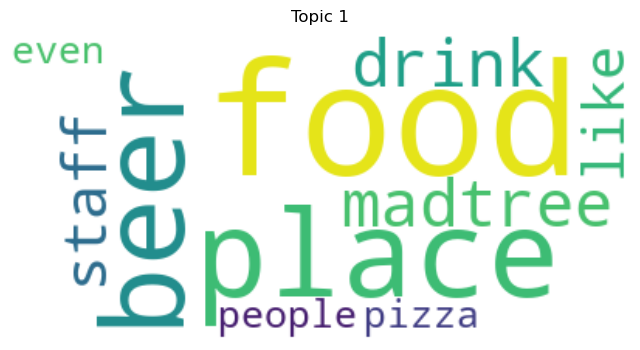

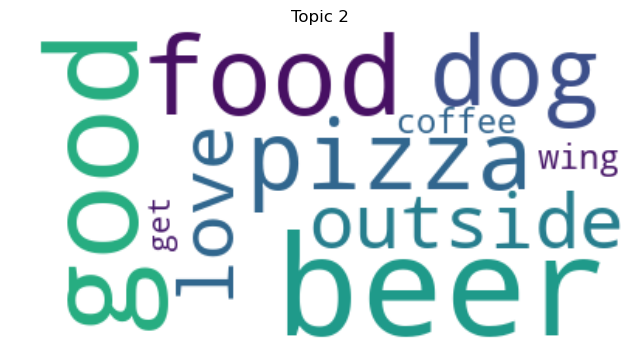

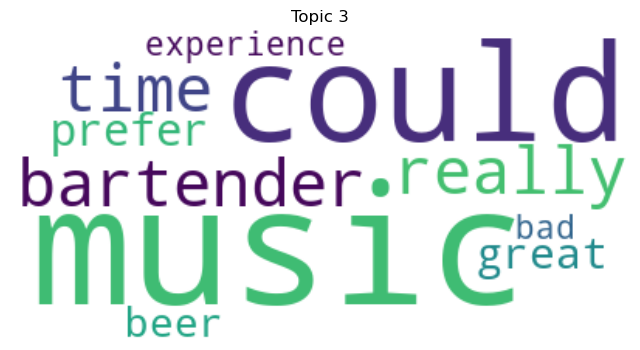

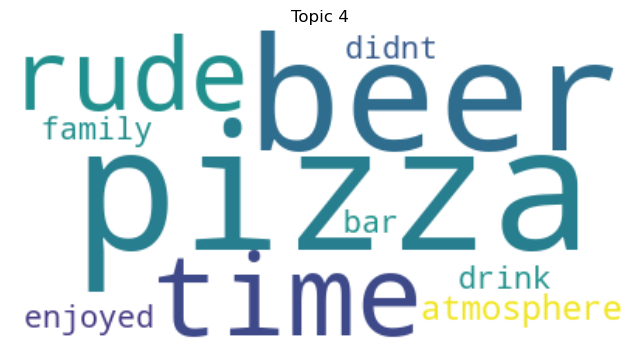

In [54]:
from wordcloud import WordCloud

# Iterate through the topics and create word clouds
for topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
    topic_words = dict(topic[1])
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic ' + str(topic[0]))
    plt.axis('off')
    plt.show()

In [55]:
# NMF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the cleaned review text
tfidf_matrix = vectorizer.fit_transform(negative_reviews['cleaned_review_text'])

# Specify number of topics
num_topics = 5

# Initialize and fit the NMF model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Print the top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_index, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_index}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 0:
kid place dog running parent screaming bar child table venue
Topic 1:
good beer area brewery loud leave outside shop large great
Topic 2:
pizza eaten hour wait enjoyed took parking beer burnt ok
Topic 3:
food ready really working service like order terrible atmosphere text
Topic 4:
drink asked rude bad time make staff said bar bartender


Let's visualize the NMF output.

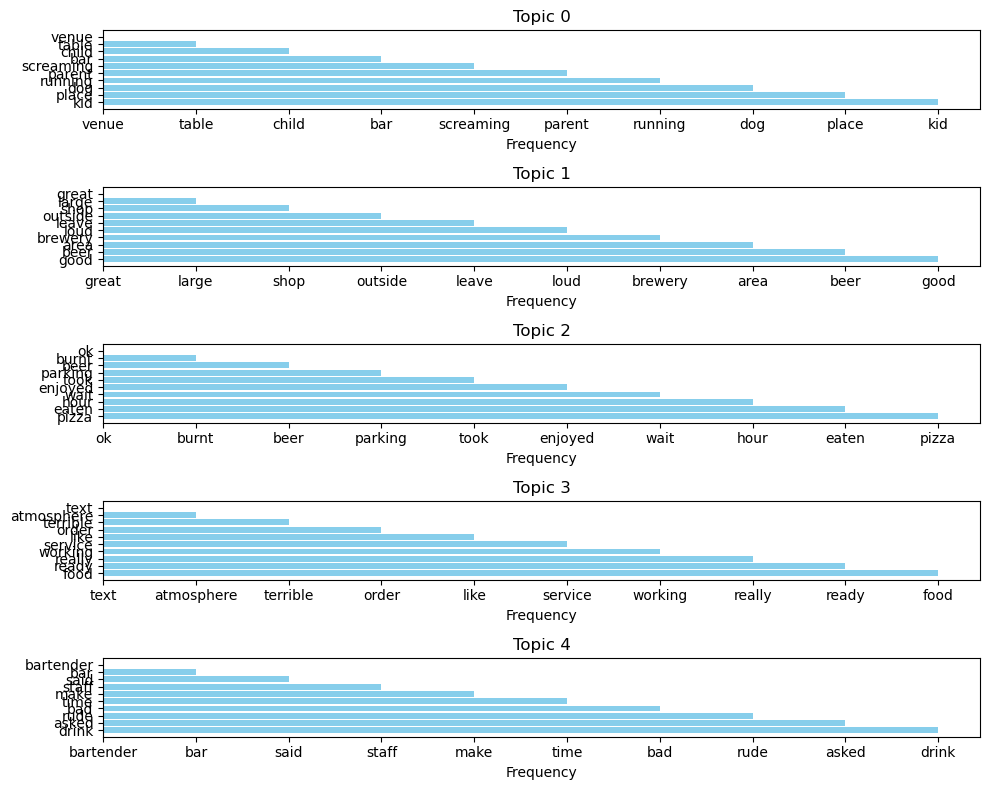

In [56]:
# Define the top words for each topic
top_words = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words.append([feature_names[i] for i in topic.argsort()[:-11:-1]])

# Plot the top words for each topic
fig, axs = plt.subplots(nrows=num_topics, figsize=(10, 8))
for i, ax in enumerate(axs):
    ax.barh(range(10), top_words[i][::-1], color='skyblue')
    ax.set_title(f'Topic {i}')
    ax.set_xlabel('Frequency')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][::-1])
plt.tight_layout()
plt.show()

#### Let's try some keyword extraction and see what we can see.

In [68]:
import re

# Define keywords for aspect extraction
aspect_keywords = {'food': ['food', 'meal', 'dish', 'pizza', 'pizzas', 'wings', 'bread', 'catch a fire', 'catch-a-fire', 'caf', 'appetizer', 'appetizers', 'pie'],
                   'service': ['service', 'waiter', 'waitress', 'staff', 'bar staff', 'bartender', 'bartenders'],
                   'parking': ['parking', 'parking lot', 'park'],
                   'beer': ['beer', 'beers', 'ipa', 'ipas', 'lager', 'stout', 'stouts', 'wine', 'brew', 'brews', 'drink', 'drinks'],
                   'cocktails': ['cocktail', 'cocktails', 'sway', 'mocktail', 'mocktails', 'mixed drinks'],
                   'dogs': ['dog', 'dogs', 'puppy'],
                   'kids': ['kid', 'kids', 'child', 'children'],
                   'price': ['price', 'prices', 'value', 'cost'],
                   'atmosphere': ['atmosphere', 'place', 'vibe', 'space', 'venue', 'crowd', 'ambiance', 'spot', 'brewery'],}

# Function to extract aspects from review text
def extract_aspects(review_text):
    aspects = []
    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            if re.search(r'\b{}\b'.format(keyword), review_text, flags=re.IGNORECASE):
                aspects.append(aspect)
                break
    return aspects

In [69]:
# Apply aspect extraction function to review text column
df['aspects'] = df['review_text'].apply(extract_aspects)
df

,date,rating,review_text,sentiment,cleaned_review_text,year_month,aspects
0,2021-07-03 00:00:00,4,I loved the food here so much. But I have to s...,positive,loved food much say service lacking food order...,2021-07,"[food, service, dogs, atmosphere]"
1,2021-07-04 00:00:00,5,"Awesome!! Love the space, large indoor space, ...",positive,awesome love space large indoor space even lar...,2021-07,"[food, beer, dogs, kids, atmosphere]"
2,2021-07-08 00:00:00,4,Busy summer evening at happy hour so tables we...,positive,busy summer evening happy hour table little ha...,2021-07,"[food, parking, beer]"
3,2021-07-09 00:00:00,4,Been here a few times and the atmosphere is de...,positive,time atmosphere decent beer well nothing reall...,2021-07,"[beer, atmosphere]"
4,2021-07-11 00:00:00,5,Just a fun place. Even though we are vaccinate...,positive,fun place even though vaccinated sat outside f...,2021-07,"[food, beer, cocktails, dogs, atmosphere]"
...,...,...,...,...,...,...,...
420,2024-03-02 22:16:00,4,"Super fun and active, great beer.",positive,super fun active great beer,2024-03,[beer]
421,2024-03-08 02:07:00,5,Authentic place. Great vibe,positive,authentic place great vibe,2024-03,[atmosphere]
422,2024-03-08 09:55:00,5,Women's International Day at MadTree Brewery. ...,positive,woman international day madtree brewery glorio...,2024-03,[atmosphere]
423,2024-03-08 10:42:00,5,Great selection of beer! We loved the atmosphere.,positive,great selection beer loved atmosphere,2024-03,"[beer, atmosphere]"


Now we have extracted the various aspects of each review. Let's try to analyze the sentiments associated with each of them.

In [88]:
# Sample DataFrame with review text and extracted aspects
test_df = pd.DataFrame({'review_text': ["The food was excellent but the service was slow.",
                                   "Great atmosphere but parking was a nightmare."],
                   'aspects': [['food', 'service'], ['atmosphere', 'parking']]})


# Function to perform sentiment analysis at aspect level
def analyze_sentiment_aspects(review_text, aspects):
    # Placeholder sentiment lexicons (replace with your actual lexicons)
    aspect_sentiment_lexicons = {
        'food': {'positive': ['excellent', 'tasty'], 'negative': ['slow', 'bland']},
        'service': {'positive': ['excellent', 'friendly'], 'negative': ['slow', 'poor']},
        'atmosphere': {'positive': ['great', 'pleasant'], 'negative': ['noisy', 'crowded']},
        'parking': {'positive': ['convenient', 'ample'], 'negative': ['nightmare', 'limited']}
    }

    aspect_sentiments = {}
    for aspect in aspects:
        sentiment_scores = {'positive': 0, 'negative': 0, 'neutral': 0}
        for word in review_text.split():
            if word.lower() in aspect_sentiment_lexicons.get(aspect, {}).get('positive', []):
                sentiment_scores['positive'] += 1
            elif word.lower() in aspect_sentiment_lexicons.get(aspect, {}).get('negative', []):
                sentiment_scores['negative'] += 1
            else:
                sentiment_scores['neutral'] += 1
        aspect_sentiments[aspect] = sentiment_scores

    return aspect_sentiments

# Apply sentiment analysis function to each row in the DataFrame
test_df['aspect_sentiments'] = test_df.apply(lambda row: analyze_sentiment_aspects(row['review_text'], row['aspects']), axis=1)
test_df

,review_text,aspects,aspect_sentiments
0,The food was excellent but the service was slow.,"[food, service]","{'food': {'positive': 1, 'negative': 0, 'neutr..."
1,Great atmosphere but parking was a nightmare.,"[atmosphere, parking]","{'atmosphere': {'positive': 1, 'negative': 0, ..."


Think we're going to need something a little more in-depth that this simple rules-based analysis. Let's try a BERT model.

In [111]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 labels: positive, negative, neutral

# Tokenize review text and aspect mentions
review_text = "The food was delicious but the service was slow."
aspect_mentions = ["food", "service"]
inputs = tokenizer(review_text, return_tensors="pt", padding=True, truncation=True)

# Add aspect embeddings or attention masks to inputs (customize this based on your model architecture)
# ...

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

print(outputs.logits.softmax(dim=1))

# Get aspect-specific sentiment predictions
aspect_sentiments = {}
for aspect in aspect_mentions:
#     aspect_index = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(aspect))[0]  # Convert aspect to token ID
    aspect_index = 2
    aspect_logits = outputs.logits[0][aspect_index].softmax(dim=0)
    aspect_sentiments[aspect] = aspect_logits.tolist()

print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("service"))[0])



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

tensor([[0.2860, 0.4825, 0.2316]])
2326
